Imports

In [41]:
from typing import Tuple
import math

import numpy as np
from numpy.random import randint, default_rng

from skimage.draw import polygon, circle_perimeter_aa, circle, circle_perimeter

import imageio as iio

import matplotlib.pyplot as plt
%matplotlib inline

import conf

# Common definitions

In [42]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['figure.dpi'] = 96

rng = default_rng()

ORIGINAL_IMAGE = iio.imread(conf.IMAGE_PATH)
ORIGINAL_IMAGE_DIMENSIONS = (ORIGINAL_IMAGE.shape[0], ORIGINAL_IMAGE.shape[1])

INITIAL_NUM_POLYGONS = int(conf.INITIAL_NUM_POLYGONS_SCALE *\
  (ORIGINAL_IMAGE_DIMENSIONS[0] * ORIGINAL_IMAGE_DIMENSIONS[1]))

## Helper functions

In [43]:
def get_random_num_polygon_vertices():
  return randint(
    conf.MIN_NUM_POLYGON_VERTICES,
    conf.MAX_NUM_POLYGON_VERTICES
  )

def get_random_circumscribed_circle_radius():
  return randint(
    conf.MIN_CIRCUMSCRIBED_CIRCLE_SIZE,
    conf.MAX_CIRCUMSCRIBED_CIRCLE_SIZE
  )

def get_random_color():
  return randint(0, 256, 3)

Define the necessary data structures

In [44]:
class ImagePolygon:
  """Contains the information to represent polygon on an image.
  Is used as gene of a chromosome.

  Attributes:
    points  Numpy array of points (numpy arrays of length 2) of an
      underlying polygon.
    color   Numpy array of 3 elements, which correspond to red, green and
      blue channels. The values must be in range 0-255.
    circumscribed_circle_center  Numpy array of length 2, containing
      coordinates of the circumscribed circle.
    circumscribed_circle_radius  Circumscribed circle radius.
  """

  points: np.ndarray
  color: np.ndarray
  circumscribed_circle_center: np.ndarray
  circumscribed_circle_radius: int

  def __init__(self,
    circle_center_position: np.ndarray,
    circle_radius:          int = None,
    num_points:             int = None,
    color:                  np.ndarray = None,
  ):
    """ Initializes a polygon for the given parameters.
    All vertices of the polygon lie on the circumscribed circle.

    :param circle_center_position: A numpy array containing a pair of coordinates
      which correspond to the center of the circumscribed circle.
    :param circle_radius: Radius of the circumscribed circle.
      Defaults to `get_random_circumscribed_circle_radius()`.
    :param num_points: Number of polygon vertices.
      Defaults to `get_random_num_polygon_vertices()`.
    :param color: Numpy array of 3 elements, which correspond to red, green
      and blue channels. The values must be in range 0-255.
      Defaults to `get_random_color()`.
    """
    if circle_radius is None:
      circle_radius = get_random_circumscribed_circle_radius()

    if num_points is None:
      num_points = get_random_num_polygon_vertices()

    if color is None:
      color = get_random_color()

    points = []

    for _ in range(num_points):
      angle = rng.uniform(0, 2 * np.pi)
      base_x = circle_radius * math.sin(angle)
      base_y = circle_radius * math.cos(angle)
      x, y = circle_center_position + (base_x, base_y)
      points.append((x, y, angle))

    points.sort(key = lambda x: x[2])
    points = [(x[0], x[1]) for x in points]

    self.points = np.array(points)
    self.color  = color
    self.circumscribed_circle_center = circle_center_position
    self.circumscribed_circle_radius = circle_radius

  def __repr__(self):
    return self.points, self.color

  def __str__(self):
    return "\n".join([
      str(self.points),
      f"Color: {self.color}",
      "Circumscribed circle:\n" +
        "\n".join([
          f"\tCenter {self.circumscribed_circle_center}",
          f"\tRadius {self.circumscribed_circle_radius}"
        ])
    ])

  def draw_on_image(self, img: np.ndarray) -> None:
    """Draws this polygon on the given image.

    :param img: Numpy array of size `n x m x 3`, representing a rgb image of
      size `n x m`.
    """
    p_x, p_y = polygon(self.points[:,0], self.points[:,1])
    img[p_x, p_y] = self.color

class Chromosome:
  """Chromosome for the genetic algorithm. Can be represented as an image.

  Consists of the polygons that constitute the underlying image.

  Attributes:
    polygons  Numpy array of polygons on the image.
    image_dimensions  Number of pixels of the underlying image by x and y
      coordinates respectively.
  """

  polygons: np.ndarray
  image_dimensions: Tuple[int, int]

  def __init__(self,
    image_dimensions: Tuple[int, int] = None,
    num_polygons: int = None
  ):
    """Initializes a chromosome by generating an image from random polygons.

    :param image_dimensions: Number of pixels of the underlying image by x
      and y coordinates respectively.
    :param num_polygons: Number of polygons to generate on the image.
    """
    if image_dimensions is None:
      image_dimensions = ORIGINAL_IMAGE_DIMENSIONS

    if num_polygons is None:
      num_polygons = INITIAL_NUM_POLYGONS

    def get_random_coordinates_on_image(limiter) -> np.ndarray:
      return np.array([
        randint(limiter, image_dimensions[0] - limiter),
        randint(limiter, image_dimensions[1] - limiter),
      ])

    polygons = []

    for _ in range(num_polygons):
      circle_radius = get_random_circumscribed_circle_radius()

      polygons.append(
        ImagePolygon(
          get_random_coordinates_on_image(circle_radius),
          circle_radius
        )
      )

    self.polygons = np.array(polygons)
    self.image_dimensions = image_dimensions

  def to_image(self, background = np.array([255, 255, 255])) -> np.ndarray:
    """Converts the chromosome to a numpy array by drawing the polygons
    on an image with the given background.

    :param background: Numpy array of size 3, which represents a background
      color of the resulting image.
    :return: Numpy array with the drawn polygons.
    """
    image = np.full(self.image_dimensions + (3,), background)

    for polygon in self.polygons:
      polygon.draw_on_image(image)

    return image

class Population:
  chromosomes: np.ndarray

  def __init__(self):
    pass

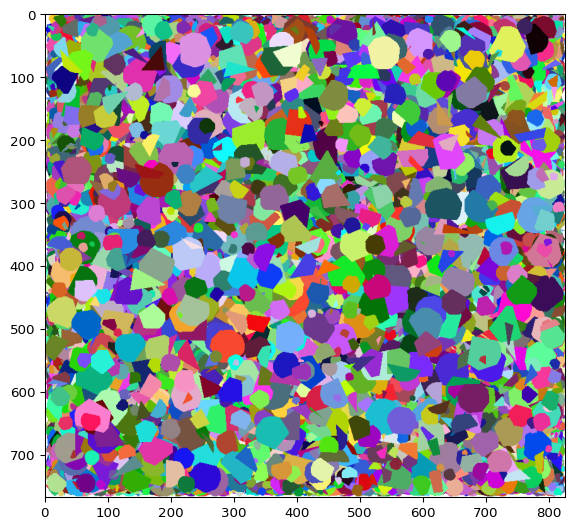

In [45]:
# Trash

# img = np.zeros((512, 512, 3))
# eX, eY, aa = circle_perimeter_aa(255, 255, 100)
# img[eX, eY] = np.outer(aa, [255, 255, 255])
# p = ImagePolygon(np.array([255, 255]))
# p.draw_on_image(img)
# plt.imshow(img.clip(0, 255).astype('uint8'))

img = Chromosome().to_image()
plt.imshow(img.clip(0, 255).astype('uint8'))

In [46]:
# Debug

# img = np.zeros(ORIGINAL_IMAGE.shape)
#
# p = np.array([
#   [688.80965409, 809.39448796],
#   [676.93993917, 800.43649012],
#   [663.04506222, 803.00335992],
#   [662.49972664, 803.38000481],
#   [655.78306841, 812.74859386],
#   [655.22124086, 820.81348958],
#   [658.41781627, 828.55272087],
#   [661.47570381, 831.82716881],
# ])
# # Color: [ 86  64 121]
# # Circumscribed circle:
# # 	Center [673 818]
# # 	Radius 18
#
# pX, pY = polygon(p[:,0], p[:,1])
#
# img[pX, pY] = [86, 64, 121]
# plt.imshow(img.clip(0, 255).astype('uint8'))


# TODOs

- [ ] generate the **initial population**
- [ ] implement the **main loop** for the GA
- [ ] implement the **fitness function**
- [ ] implement the **mutation** method for a `Chromosome`
  - add new polygon
  - remove an existing polygon
  - change an existing polygon
    - reshape
    - change color
  - move an existing polygon
- [ ] implement the **crossover** method for a `Chromosome`
- [ ] implement the **selection** method for a population
